In [50]:
import boto3
import pandas as pd
import numpy as np
import math
from sagemaker import get_execution_role
import json
import s3fs
import gzip
import pickle
from datetime import datetime 

In [51]:
#Pull in game data
out_path = '../common/data/'

#player data
player = pd.read_pickle(out_path + 'player_play_rect.pkl')
#play data
play = pd.read_pickle(out_path + 'withTOR_play_rect.pkl')
play_df = pd.DataFrame(play, columns=['playId', 'gameId', 'play_type',
                                      'yardlineNumber', 'playDesc', 
                                      'dInBox','dRushers', 'sack', 'qb_hit', 'ReleaseTime']) 
#ball position data
ball_pos = pd.read_pickle(out_path + 'ball_rect.pkl')

In [52]:
play.columns

Index(['gameId', 'playId', 'home_team', 'away_team', 'homeScore',
       'visitorScore', 'quarter', 'gameClock', 'startTime', 'endTime',
       'snapTime', 'possessionTeam', 'playDesc', 'playType', 'playTypeCode',
       'down', 'ydstogo', 'play_type', 'isGoalToGo', 'yardlineNumber',
       'yardlineSide', 'absoluteYardlineNumber', 'isRedzonePlay', 'isScoring',
       'isPenalty', 'oForm', 'dInBox', 'RB', 'TE', 'WR', 'DL', 'LB', 'DB',
       'dRushers', 'shotgun', 'no_huddle', 'qb_dropback', 'qb_scramble',
       'pass_location', 'air_yards', 'run_location', 'run_gap', 'ep', 'epa',
       'wp', 'home_wp', 'wpa', 'first_down_rush', 'first_down_pass',
       'third_down_converted', 'third_down_failed', 'fourth_down_converted',
       'fourth_down_failed', 'incomplete_pass', 'interception',
       'fumble_forced', 'tackled_for_loss', 'fumble_lost', 'qb_hit',
       'rush_attempt', 'pass_attempt', 'sack', 'fumble', 'complete_pass',
       'tackle_for_loss_1_player_id', 'tackle_for_loss_1_p

In [53]:
#merge with d in box + rushers
d = pd.merge(player, play_df, how='inner', on=['playId', 'gameId'])
d1 = pd.DataFrame(d, columns=['playId', 'gameId', 'displayName', 'position', 'positionGroup', 'coordinates', 'play_type', 'yardlineNumber', 'playDesc', 'dInBox','dRushers', 'sack', 'qb_hit', 'snapTime', 'ReleaseTime'])
df_merged = d1.merge(ball_pos, on=['playId', 'gameId'], how='inner') 
# ds_subs = d1[0:5000]
df_merged.shape

(575435, 18)

In [54]:
df_merged['unique_key'] = df_merged['gameId'].astype(str) + "_" + df_merged['playId'].astype(str)

In [55]:
df_merged.unique_key.nunique()

26154

In [56]:
count_chk = df_merged.groupby(['unique_key'])['position'].count().reset_index()

In [57]:
count_chk.groupby('position')['unique_key'].count()

position
21       80
22    25968
23       89
24       15
26        2
Name: unique_key, dtype: int64

In [58]:
drop_keys = count_chk[count_chk['position'] != 22]['unique_key'].to_list()

In [59]:
df_merged = df_merged[~df_merged['unique_key'].isin(drop_keys)]

In [60]:
df_merged.unique_key.nunique()

25968

# Create Blitzing Features

In [61]:
df_merged = df_merged[df_merged['coordinates'].map(len) > 50]

In [62]:
df_merged.ReleaseTime.describe()

count                         318560
unique                         14480
top       2019-10-27 17:05:13.184000
freq                              22
first     2019-09-06 00:24:04.625000
last      2019-12-30 04:23:57.870000
Name: ReleaseTime, dtype: object

In [112]:
df_merged['releaseIdx'] = df_merged.apply(lambda row: math.ceil((row.ReleaseTime - datetime.strptime(row.snapTime, '%Y-%m-%d %H:%M:%S.%f')).total_seconds() * 10) + 20, axis = 1)


SyntaxError: invalid syntax (<ipython-input-112-2d4297fa3791>, line 1)

In [64]:
#pull xy coordinates for snap & play end
x=0
for i in df_merged:
    x_snap = lambda x: x[20][0]
    y_snap = lambda x: x[20][1]
    ball_x_snap = lambda x: x[20][0]
    ball_y_snap = lambda x: x[20][1]
    x_1s = lambda x: x[30][0]
    y_1s = lambda x: x[30][1]
    x_3s = lambda x: x[50][0]
    y_3s = lambda x: x[50][1]
    x_2s = lambda x: x[40][0]
    y_2s = lambda x: x[40][1]
    x_end = lambda x: x[-11][0]
    y_end = lambda x: x[-11][1]
    
    df_merged['x_snap'] = df_merged['coordinates'].apply(x_snap)
    df_merged['y_snap'] = df_merged['coordinates'].apply(y_snap)
    df_merged['x_snap_ball'] = df_merged['ballTrack'].apply(ball_x_snap)
    df_merged['y_snap_ball'] = df_merged['ballTrack'].apply(ball_y_snap)
    df_merged['x_1s'] = df_merged['coordinates'].apply(x_1s)
    df_merged['y_1s'] = df_merged['coordinates'].apply(y_1s)
    df_merged['x_3s'] = df_merged['coordinates'].apply(x_3s)
    df_merged['y_3s'] = df_merged['coordinates'].apply(y_3s)
    df_merged['x_2s'] = df_merged['coordinates'].apply(x_2s)
    df_merged['y_2s'] = df_merged['coordinates'].apply(y_2s)
    df_merged['x_end'] = df_merged['coordinates'].apply(x_end)
    df_merged['y_end'] = df_merged['coordinates'].apply(y_end)
    

    
print(df_merged.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 564322 entries, 0 to 575434
Data columns (total 31 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   playId          564322 non-null  int64         
 1   gameId          564322 non-null  int64         
 2   displayName     564322 non-null  object        
 3   position        564322 non-null  object        
 4   positionGroup   564322 non-null  object        
 5   coordinates     564322 non-null  object        
 6   play_type       563376 non-null  object        
 7   yardlineNumber  556820 non-null  float64       
 8   playDesc        564322 non-null  object        
 9   dInBox          563134 non-null  float64       
 10  dRushers        322674 non-null  float64       
 11  sack            563376 non-null  float64       
 12  qb_hit          563376 non-null  float64       
 13  snapTime        564322 non-null  object        
 14  ReleaseTime     318560 non-null  dat

In [14]:
# #Create LOS & QB position
# c = df_merged[df_merged.position == 'C']
# c['los'] = c['x_snap'] #line of scrimmage
# c = pd.DataFrame(c, columns=['playId', 'gameId', 'los'])
# #c.shape

# qb = df_merged[df_merged.position == 'QB']
# qb['qb_xend'] = qb['x_end'] #QB at end of play
# qb['qb_yend'] = qb['y_end'] #QB at end of play
# qb = pd.DataFrame(qb, columns=['playId', 'gameId', 'qb_xend', 'qb_yend'])
# #qb.shape

# c_qb = pd.merge(c, qb, how='left', on=['playId', 'gameId'])

# ds = pd.merge(df_merged, c_qb, how='left', on=['playId', 'gameId'])

In [65]:
count_chk = df_merged.groupby(['unique_key'])['position'].count().reset_index()

In [66]:
count_chk.groupby('position')['unique_key'].count()

position
22    25651
Name: unique_key, dtype: int64

In [67]:
ds = df_merged[df_merged['play_type'] == 'pass']

In [68]:
ds.shape[0]

321596

In [69]:
team_mapping = {'DB': 'defense', 'OL': 'offense', 'LB': 'defense', 'DL': 'defense', 
                'WR': 'offense', 'RB': 'offense', 'TE': 'offense', 'QB': 'offense'}

In [70]:
ds['player_side'] = ds.positionGroup.map(team_mapping)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [71]:
#add qb locations to all rows in play
ds_qb = ds[ds['position'] == 'QB']
ds_qb['qb_x_snap'] = ds_qb['x_snap']
ds_qb['qb_x_1s'] = ds_qb['x_1s']
ds_qb['qb_x_2s'] = ds_qb['x_2s']
ds_qb['qb_x_3s'] = ds_qb['x_3s']
ds_qb['qb_y_snap'] = ds_qb['y_snap']
ds_qb['qb_y_1s'] = ds_qb['y_1s']
ds_qb['qb_y_2s'] = ds_qb['y_2s']
ds_qb['qb_y_3s'] = ds_qb['y_3s']
ds_qb = ds_qb[['gameId', 'playId', 'qb_x_snap', 'qb_x_1s', 'qb_x_2s', 'qb_x_3s', 'qb_y_snap', 'qb_y_1s', 'qb_y_2s', 'qb_y_3s']]
ds = pd.merge(ds, ds_qb, how = 'left', on = ['gameId', 'playId'])

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_

In [72]:
ds.shape[0]

321596

In [23]:
# #create movement variables
# ds['vertPlay'] = ds['x_end'] - ds['x_snap']
# ds['horizPlay'] = ds['y_end'] - ds['y_snap']
# ds['vert3s'] = ds['x_3s'] - ds['x_snap']
# ds['horiz3s'] = ds['y_3s'] - ds['y_snap']
# ds['vert1s_toLOS'] = ds['x_1s'] - ds['x_snap_ball']
# ds['horizs_toLOS'] = ds['y_1s'] - ds['y_snap_ball']
# ds['vert3s_toLOS'] = ds['x_3s'] - ds['x_snap_ball']
# ds['horiz3s_toLOS'] = ds['y_3s'] - ds['y_snap_ball']
# ds['xfromQB'] = abs(ds['qb_xend'] - ds['x_end'])
# ds['yfromQB'] = abs(ds['qb_yend'] - ds['y_end'])
# ds['QBHurry'] = ds['xfromQB'] < 1
#ds['vert3s_abs'] = abs(ds['x_3s'] - ds['x_snap'])
#ds['horiz3s_abs'] = abs(ds['y_3s'] - ds['y_snap'])
#ds['magnitude'] = math.sqrt((ds['y_end']-ds['y_snap'])**2 + (ds['x_end']-ds['x_snap'])**2)
#ds['angle'] = math.atan2((ds['y_end']-ds['y_snap']),(ds['x_end']-ds['x_snap']))*(180/(math.pi))

In [79]:
ds['x_player_pos_v_LOS'] = ds['x_snap'] - ds['x_snap_ball']
ds['y_player_pos_v_LOS'] = ds['y_snap'] - ds['y_snap_ball']
ds['x_1s_toLOS'] = ds['x_1s'] - ds['x_snap_ball']
ds['y_1s_toLOS'] = ds['y_1s'] - ds['y_snap_ball']
ds['x_2s_toLOS'] = ds['x_2s'] - ds['x_snap_ball']
ds['y_2s_toLOS'] = ds['y_2s'] - ds['y_snap_ball']
ds['x_3s_toLOS'] = ds['x_3s'] - ds['x_snap_ball']
ds['y_3s_toLOS'] = ds['y_3s'] - ds['y_snap_ball']
ds['qb_dist_snap'] = ((ds['x_snap'] - ds['qb_x_snap'])**2 + (ds['y_snap'] - ds['qb_y_snap'])**2)**0.5
ds['qb_dist_1s'] = ((ds['x_1s'] - ds['qb_x_1s'])**2 + (ds['y_1s'] - ds['qb_y_1s'])**2)**0.5
ds['qb_dist_2s'] = ((ds['x_2s'] - ds['qb_x_2s'])**2 + (ds['y_2s'] - ds['qb_y_2s'])**2)**0.5
ds['qb_dist_3s'] = ((ds['x_3s'] - ds['qb_x_3s'])**2 + (ds['y_3s'] - ds['qb_y_3s'])**2)**0.5

In [80]:
ds[(ds['playId'] == 424) & (ds['gameId'] == 2019090500)][['displayName', 'player_side', 'position', 'y_snap', 'y_snap_ball']]

,displayName,player_side,position,y_snap,y_snap_ball
110,Bryan Bulaga,offense,OT,29.47,26.05
111,Jimmy Graham,offense,TE,32.64,26.05
112,Prince Amukamara,defense,CB,12.74,26.05
113,Buster Skrine,defense,CB,16.40,26.05
114,Aaron Rodgers,offense,QB,25.88,26.05
115,Danny Trevathan,defense,ILB,22.20,26.05
116,Akiem Hicks,defense,DT,20.10,26.05
117,David Bakhtiari,offense,T,22.44,26.05
118,Lane Taylor,offense,G,24.30,26.05
119,Khalil Mack,defense,OLB,31.56,26.05


In [81]:
def_pl = ds[(ds.player_side == 'defense') ]

In [82]:
def_pl['x_player_pos_v_LOS'].describe()


count    160717.000000
mean         -4.433578
std           4.598220
min         -58.050000
25%          -6.000000
50%          -2.570000
75%          -1.110000
max          18.340000
Name: x_player_pos_v_LOS, dtype: float64

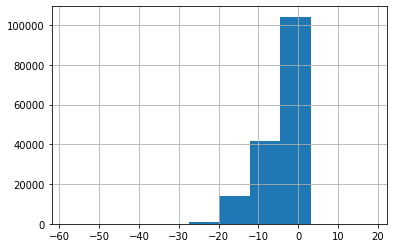

In [83]:
def_pl['x_player_pos_v_LOS'].hist()

In [84]:
def_pl[def_pl['x_player_pos_v_LOS'] >= 0.5]['unique_key'].count()

87

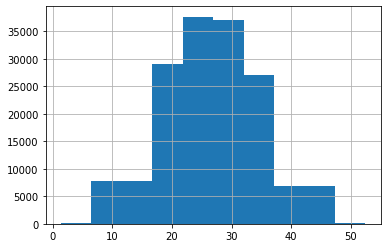

In [85]:
def_pl['y_snap'].hist()

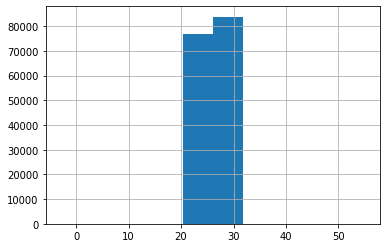

In [86]:
def_pl['y_snap_ball'].hist()

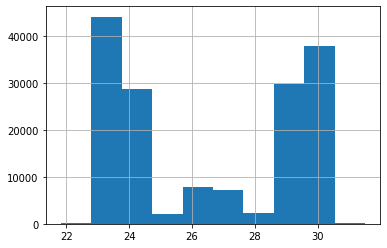

In [87]:
def_pl['y_snap_ball'][(def_pl['y_snap_ball'] <35) & (def_pl['y_snap_ball'] > 20)].hist()

In [92]:
def_pl = ds[(ds.player_side == 'defense') & (def_pl.x_player_pos_v_LOS < 0.5)]
def_pl['towardLOS'] = (def_pl['x_1s_toLOS'] > def_pl['x_player_pos_v_LOS'])
def_pl['towardLOS2'] = (def_pl['x_3s_toLOS'] > def_pl['x_player_pos_v_LOS'])
def_pl['crossLOS']  = (def_pl['x_2s_toLOS'] > -0.2)
def_pl['crossLOS2']  = (def_pl['x_1s_toLOS'] > -0.2)
def_pl['y_bounds'] = ((abs(def_pl['y_1s'] - def_pl['y_snap_ball']) < 7))
def_pl['y_bounds2'] = ((abs(def_pl['y_3s'] - def_pl['y_snap_ball']) < 6))
def_pl['DL_position'] = (def_pl['positionGroup'] == 'DL')
#def_pl['rusher'] = (((def_pl['crossLOS2'] == True) | (def_pl['crossLOS'] == True)) &
#                  ((def_pl['towardLOS'] == True) | (def_pl['towardLOS2'] == True)) &
#                   ((def_pl['y_bounds'] == True) | (def_pl['y_bounds2'] == True)))  #| (def_pl['DL_position'] == True)

def_pl['rusher'] = (((def_pl['crossLOS2'] == True) | (def_pl['crossLOS'] == True)) & ((def_pl['y_bounds'] == True) | (def_pl['y_bounds2'] == True))) 
# def_pl['rusher'] = (((def_pl['crossLOS2'] == True) | (def_pl['crossLOS'] == True)) & ((def_pl['y_bounds'] == True) | (def_pl['y_bounds2'] == True)) 
#                        | (def_pl['DL_position'] == True)) 

#def_pl['rusher'] = def_pl['crossLOS'] & def_pl['y_bounds']





/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a D

In [93]:
# def_pl = ds[(ds.player_side == 'defense') & (def_pl.x_player_pos_v_LOS < 0.5)]
# def_pl['DL_position'] = (def_pl['positionGroup'] == 'DL')
# def_pl['towardsQB_2s'] = (ds['qb_dist_snap'] > ds['qb_dist_2s'])
# def_pl['towardsQB_1s'] = (ds['qb_dist_snap'] > ds['qb_dist_1s'])
# def_pl['towardsQB_3s'] = (ds['qb_dist_snap'] > ds['qb_dist_3s'])
# def_pl['y_bounds_2s'] = ((abs(def_pl['y_2s'] - def_pl['y_snap_ball']) < 7))
# def_pl['crossLOS_1s']  = (def_pl['x_1s_toLOS'] > -0.1)
# def_pl['crossLOS_2s']  = (def_pl['x_2s_toLOS'] > -0.1)
# def_pl['crossLOS_3s']  = (def_pl['x_3s_toLOS'] > -0.1)
# def_pl['rusher'] = (def_pl['DL_position'] == True) | (((def_pl['towardsQB_1s'] == True) | (def_pl['towardsQB_2s'] == True) | (def_pl['towardsQB_3s'] == True)) & 
#                         ((def_pl['crossLOS_3s'] == True) | (def_pl['crossLOS_2s'] == True) | (def_pl['crossLOS_1s'] == True)) )


In [94]:
rusher = def_pl[(def_pl['rusher']) == True].groupby(['gameId', 'playId', 'dRushers'])['rusher'].sum().reset_index(name='rusher_cnt')

In [95]:
rusher['diff'] = rusher['dRushers'] - rusher['rusher_cnt']

In [96]:
rusher['diff'].value_counts()

 0.0    11545
-1.0     1300
 1.0     1265
 2.0      233
-2.0      158
 3.0       40
-3.0       15
 4.0       12
-4.0        5
-5.0        1
Name: diff, dtype: int64

In [97]:
len(rusher)

14574

In [98]:
11545/14614

0.7899958943478856

In [99]:
rusher[rusher['diff'] == 1].head(10)

,gameId,playId,dRushers,rusher_cnt,diff
0,2019090500,71,4.0,3.0,1.0
16,2019090500,1909,4.0,3.0,1.0
21,2019090500,2488,4.0,3.0,1.0
40,2019090800,666,3.0,2.0,1.0
54,2019090800,2678,5.0,4.0,1.0
56,2019090800,3231,2.0,1.0,1.0
59,2019090800,3383,4.0,3.0,1.0
84,2019090801,1640,5.0,4.0,1.0
89,2019090801,2401,6.0,5.0,1.0
94,2019090801,3416,5.0,4.0,1.0


In [100]:
def_pl.shape[0]

160630

In [101]:
def_pl.positionGroup.value_counts()

DB    73932
DL    44519
LB    42179
Name: positionGroup, dtype: int64

In [102]:
def_pl[def_pl['playId'] == 424]

,playId,gameId,displayName,position,positionGroup,coordinates,play_type,yardlineNumber,playDesc,dInBox,...,qb_dist_2s,qb_dist_3s,towardLOS,towardLOS2,crossLOS,crossLOS2,y_bounds,y_bounds2,DL_position,rusher
112,424,2019090500,Prince Amukamara,CB,DB,"[[95.75, 12.82], [95.74, 12.81], [95.73, 12.8]...",pass,12.0,(Shotgun) A.Rodgers sacked at GB 5 for -7 yard...,5.0,...,22.181582,26.841753,False,False,False,False,False,False,False,False
113,424,2019090500,Buster Skrine,CB,DB,"[[95.1, 16.27], [95.1, 16.3], [95.1, 16.32], [...",pass,12.0,(Shotgun) A.Rodgers sacked at GB 5 for -7 yard...,5.0,...,16.562322,14.359098,False,False,False,False,False,False,False,False
115,424,2019090500,Danny Trevathan,ILB,LB,"[[94.61, 21.91], [94.59, 21.99], [94.56, 22.06...",pass,12.0,(Shotgun) A.Rodgers sacked at GB 5 for -7 yard...,5.0,...,5.542391,3.021854,True,True,True,False,True,True,False,True
116,424,2019090500,Akiem Hicks,DT,DL,"[[97.42, 20.27], [97.43, 20.23], [97.44, 20.18...",pass,12.0,(Shotgun) A.Rodgers sacked at GB 5 for -7 yard...,5.0,...,5.685297,1.660903,True,True,True,True,True,True,True,True
119,424,2019090500,Khalil Mack,OLB,LB,"[[97.61, 31.61], [97.61, 31.61], [97.61, 31.61...",pass,12.0,(Shotgun) A.Rodgers sacked at GB 5 for -7 yard...,5.0,...,2.674416,1.090046,True,True,True,True,True,True,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
315911,424,2019122912,Vita Vea,DT,DL,"[[21.7, 29.32], [21.7, 29.31], [21.69, 29.31],...",pass,13.0,(Shotgun) M.Ryan pass incomplete short middle ...,7.0,...,3.722472,2.406200,True,True,True,True,True,True,True,True
315912,424,2019122912,Carlton Davis,CB,DB,"[[14.28, 38.06], [14.28, 38.04], [14.27, 38.03...",pass,13.0,(Shotgun) M.Ryan pass incomplete short middle ...,7.0,...,16.547281,19.296520,True,False,False,False,False,True,False,False
315917,424,2019122912,Jamel Dean,CB,DB,"[[15.43, 18.55], [15.42, 18.55], [15.41, 18.55...",pass,13.0,(Shotgun) M.Ryan pass incomplete short middle ...,7.0,...,20.515294,24.006976,False,False,False,False,False,False,False,False
315918,424,2019122912,Sean Murphy-Bunting,DB,DB,"[[19.73, 21.32], [19.8, 21.28], [19.89, 21.22]...",pass,13.0,(Shotgun) M.Ryan pass incomplete short middle ...,7.0,...,17.067071,20.987792,False,False,False,False,False,False,False,False


In [44]:
#create variables for defenders rushing _ SFA


#def_pl = ds[(ds.player_side == 'defense')]
#def_pl['towardLOS'] = ((def_pl['x_player_pos_v_LOS'] < 0) & (def_pl['x_1s_toLOS'] > def_pl['x_player_pos_v_LOS'])) | ((def_pl['x_player_pos_v_LOS'] > 0) & (def_pl['x_1s_toLOS'] < def_pl['x_player_pos_v_LOS'])) 
#def_pl['towardLOS2'] = ((def_pl['x_player_pos_v_LOS'] < 0) & (def_pl['x_3s_toLOS'] > def_pl['x_player_pos_v_LOS'])) | ((def_pl['x_player_pos_v_LOS'] > 0) & (def_pl['x_3s_toLOS'] < def_pl['x_player_pos_v_LOS'])) 
#def_pl['crossLOS']  = ((def_pl['x_player_pos_v_LOS'] < 0) & (def_pl['x_3s_toLOS'] > 0)) | ((def_pl['x_player_pos_v_LOS'] > 0) & (def_pl['x_3s_toLOS'] < 0))
#def_pl['crossLOS2']  = ((def_pl['x_player_pos_v_LOS'] < 0) & (def_pl['x_1s_toLOS'] > 0)) | ((def_pl['x_player_pos_v_LOS'] > 0) & (def_pl['x_1s_toLOS'] < 0))
#def_pl['bounds'] = ((abs(def_pl['x_1s'] - def_pl['x_snap_ball']) < 15) & (abs(def_pl['y_1s'] - def_pl['y_snap_ball']) < 7))
#def_pl['bounds2'] = ((abs(def_pl['x_3s'] - def_pl['x_snap_ball']) < 15) & (abs(def_pl['y_3s'] - def_pl['y_snap_ball']) < 7))
#def_pl['DL_position'] = (def_pl['positionGroup'] == 'DL')
#def_pl['rusher'] = ((((def_pl['crossLOS2'] == True) | (def_pl['crossLOS'] == True)) &
#                     ((def_pl['towardLOS'] == True) | (def_pl['towardLOS2'] == True)) &
#                    ((def_pl['bounds'] == True) | (def_pl['bounds2'] == True)) | (def_pl['DL_position'] == True)))


In [45]:
# #create variables for defenders rushing
# def_pl = ds[(ds.player_side == 'defense')]
# def_pl['towardLOS'] = abs(def_pl['x_snap'] - def_pl['los']) > abs(def_pl['x_3s'] - def_pl['los'])
# def_pl['crossLOS1'] = (def_pl['x_snap'] > def_pl['los']) & (def_pl['x_end'] < def_pl['los'])
# def_pl['crossLOS2'] = (def_pl['x_snap'] < def_pl['los']) & (def_pl['x_end'] > def_pl['los'])
# def_pl['crossLOS3'] = (def_pl['x_snap'] < def_pl['los']) & (def_pl['x_3s'] > def_pl['los'])
# def_pl['crossLOS4'] = (def_pl['x_snap'] > def_pl['los']) & (def_pl['x_3s'] < def_pl['los'])
# def_pl['crossLOS'] = (def_pl['crossLOS1'] == True) | (def_pl['crossLOS2'] == True) | (def_pl['crossLOS3'] == True) | (def_pl['crossLOS4'] == True)
# def_pl['closeLOS'] = abs(def_pl['x_end'] - def_pl['los']) < 1
# def_pl['rusher'] = (def_pl['crossLOS'] | def_pl['towardLOS']) & (abs(def_pl['x_snap'] - def_pl['los']) < 3)
# def_pl_df = pd.DataFrame(def_pl, columns=['playId', 'gameId', 'displayName', 'position', 'positionGroup', 'play_type', 'playDesc', 'dInBox', 'dRushers', 'sack', 'qb_hit', 'los', 'x_snap', 'x_3s', 'towardLOS', 'xfromQB', 'yfromQB', 'QBHurry', 'crossLOS', 'closeLOS', 'rusher'])

In [46]:
#def_pl[def_pl['crossLOS2'] == True] #plays 2179, 71, 93, 147
#def_pl[def_pl['sack'] == 1] #play 126, 95, 380, 1269
#def_pl[def_pl['rusher'] == True]
# pd.set_option('display.max_columns', None)
# def_pl_df[def_pl_df['playId'] == 424].sort_values(by=['xfromQB'])

In [69]:
# def_pl_df.play_type.value_counts()

In [70]:
# cross = pd.DataFrame(def_pl_df[(def_pl_df['play_type'] == 'pass') & (def_pl_df['crossLOS']) == True].groupby(['playId', 'dRushers'])['crossLOS'].value_counts().reset_index(name='crossLOS_cnt'))
# cross['match'] = cross['dRushers'] == cross['crossLOS_cnt']
# cross.groupby('dRushers')['match'].value_counts()

In [45]:
counts = def_pl.groupby(['unique_key'])['position'].count().reset_index()

In [46]:
counts.groupby('position')['unique_key'].count()

position
1         2
2         1
3         1
6         1
7         1
9         5
10      101
11    14505
Name: unique_key, dtype: int64

In [47]:
def_pl['position'].unique()

array(['CB', 'ILB', 'DT', 'OLB', 'FS', 'LB', 'SS', 'NT', 'DE', 'DB',
       'MLB', 'S', 'DL'], dtype=object)

In [48]:
def_pl.shape[0]

160630

In [74]:
drop_keys = counts[counts['position'] == 10]['unique_key'].to_list()

In [51]:
def_pl = def_pl[~def_pl['unique_key'].isin(drop_keys)]

In [52]:
def_pl.shape[0]

160674

In [83]:
316/409

0.7726161369193154

In [85]:
326/409

0.7970660146699267

In [81]:
len(rusher)

409

In [79]:
(316/len(rusher))

0.7726161369193154

In [103]:
rusher_blitz = rusher[rusher['dRushers'] >= 5]

In [105]:
rusher

,gameId,playId,dRushers,rusher_cnt,diff
0,2019090500,71,4.0,3.0,1.0
1,2019090500,95,4.0,4.0,0.0
2,2019090500,381,4.0,4.0,0.0
3,2019090500,424,5.0,5.0,0.0
4,2019090500,676,2.0,2.0,0.0
...,...,...,...,...,...
14569,2019122915,3807,5.0,5.0,0.0
14570,2019122915,3877,5.0,4.0,1.0
14571,2019122915,3955,4.0,4.0,0.0
14572,2019122915,3977,4.0,4.0,0.0


In [106]:
rusher_blitz

,gameId,playId,dRushers,rusher_cnt,diff
3,2019090500,424,5.0,5.0,0.0
5,2019090500,698,5.0,5.0,0.0
9,2019090500,1404,5.0,5.0,0.0
15,2019090500,1885,5.0,5.0,0.0
23,2019090500,2606,5.0,5.0,0.0
...,...,...,...,...,...
14566,2019122915,3722,6.0,6.0,0.0
14567,2019122915,3746,5.0,6.0,-1.0
14568,2019122915,3768,5.0,5.0,0.0
14569,2019122915,3807,5.0,5.0,0.0


In [107]:
rusher_blitz['diff'].value_counts()

 0.0    3084
 1.0     675
-1.0     333
 2.0     125
 3.0      23
-2.0      20
 4.0      12
-3.0       2
Name: diff, dtype: int64

In [110]:
3084/len(rusher_blitz)

0.7215722976134769

In [108]:
rusher_blitz_matches = rusher_blitz[rusher_blitz['diff'] == 0]

In [109]:
rusher_blitz_matches[['gameId', 'playId']].to_csv('../common/data/blitz_plays.csv', index=False)

In [517]:
rusher = pd.DataFrame(def_pl[(def_pl['rusher']) == True].groupby(['playId', 'dRushers'])['rusher'].value_counts().reset_index(name='rusher_cnt'))
rusher['match'] = rusher['dRushers'] == rusher['rusher_cnt']
rusher['match'].value_counts()

True     312
False     99
Name: match, dtype: int64

In [518]:
rusher2 = def_pl_df[(def_pl_df['rusher'] == True)].groupby(['playId', 'dRushers', 'sack'])['rusher'].value_counts().reset_index(name='rusher_cnt')
rusher2['match'] = abs(rusher2['dRushers'] - rusher2['rusher_cnt']) < 2
rusher2['match'].value_counts()

True     247
False    125
Name: match, dtype: int64

In [30]:
ds.groupby(['positionGroup', 'dRushers'])['xfromQB'].mean()

positionGroup  dRushers
DB             0.0          9.795000
               1.0         13.345000
               2.0         20.288140
               3.0         20.581045
               4.0         21.397761
               5.0         18.783916
               6.0         16.984000
DL             0.0          4.546000
               1.0          8.086000
               2.0          8.493333
               3.0          7.163200
               4.0          5.030720
               5.0          5.267368
               6.0          5.876000
LB             0.0          5.328571
               1.0         11.484286
               2.0         10.731111
               3.0         10.812750
               4.0         10.271236
               5.0          7.494273
               6.0          6.111429
OL             0.0          3.683000
               1.0          8.777000
               2.0          8.150750
               3.0          6.091833
               4.0          4.265453
              

In [28]:
#ds.to_pickle('../common/data/blitzing_metrics.pkl')